In [1]:
import json
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.lines import Line2D
import matplotlib.gridspec as gridspec
from IPython.display import display
from scipy.stats import wilcoxon, probplot, ranksums, ttest_ind, ttest_1samp, pearsonr, spearmanr
import matplotlib.patches as patches
from matplotlib import rc
from matplotlib.patches import FancyArrowPatch
from statsmodels.stats import multitest
import statsmodels.api as sm
from Figures import utils
import json
from matplotlib.markers import MarkerStyle
from pipeline.DNNs import DeTaillez, EEGNet
from pipeline.linear_models import Ridge
import pickle
from pipeline.datasets import OctaveMapped
from torch.utils.data import DataLoader
import torch
from scipy.optimize import curve_fit

fs = 12*1.3
mpl.rcParams['axes.titlesize'] = fs
mpl.rcParams['axes.labelsize'] = fs
mpl.rcParams['xtick.labelsize'] = fs
mpl.rcParams['ytick.labelsize'] = fs
mpl.rcParams['legend.fontsize'] = 12
title=True

rc('text', usetex=True)

In [2]:
# similarity metrics

def med_ae(x,y):
    return np.median(np.abs(x-y))

def med_se(x,y):
    return np.median(np.square(x-y))

def mean_se(x,y):
    return np.mean(np.square(x-y))

def trim_mean_se(x,y,trim=0.1):
    return trim_mean(np.square(x-y), trim).mean()
    
def trim_med_ae(x,y,trim=0.1):
    return np.median(trim_mean(np.abs(x-y), trim))

def spear(x,y):
    return spearmanr(x, y)[0]

def pear(x,y):
    return pearsonr(x, y)[0]

def var_se(x,y):
    w,v = np.linalg.eigh(np.cov(x, y))
    return np.cov(x, y)[1,0]

def std_ae(x,y):
    return np.std(np.abs(x-y))

# What happens when the data is filteres in different bands? 

In [10]:
def load_hugo_data(study="individuals", prediction_window=250, results_path="/home/mdt20/Code/mldecoders/results/", band="0.5-12Hz"):
    
    dfs = {}
    for model in ["ridge", "eegnet", "detaillez"]:
        r = json.load(open(os.path.join(results_path, band, model, study + "_results_{}".format(prediction_window) + ".json"), "r"))
        dfs[model] = pd.DataFrame.from_dict(r).transpose()
        utils._h_add_pvalue(dfs[model], test='notnull')
        dfs[model].index = dfs[model].index.rename("participant")
        dfs[model]['names'] = utils._h_participant_names
        dfs[model]["means"] = [np.mean(x) for x in dfs[model]["correlations"]]
        dfs[model]["medians"] = [np.median(x) for x in dfs[model]["correlations"]]
        dfs[model]["stds"] = [np.std(x) for x in dfs[model]["correlations"]]
        dfs[model]["null_means"] = [np.mean(x) for x in dfs[model]["null_correlations"]]
        dfs[model]["null_medians"] = [np.median(x) for x in dfs[model]["null_correlations"]]
        dfs[model]["null_stds"] = [np.std(x) for x in dfs[model]["null_correlations"]]

        dfs[model]["25%"] = [np.percentile(dfs[model].loc[str(i)]["correlations"], 25) for i in range(13)]
        dfs[model]["75%"] = [np.percentile(dfs[model].loc[str(i)]["correlations"], 75) for i in range(13)]
        dfs[model]["null_95%"] = [np.std(x) for x in dfs[model]["null_correlations"]]
        dfs[model]["null_25%"] = [np.percentile(dfs[model].loc[str(i)]["null_correlations"], 25) for i in range(13)] - dfs[model]["null_means"]
        dfs[model]["null_75%"] = [np.percentile(dfs[model].loc[str(i)]["null_correlations"], 75) for i in range(13)] - dfs[model]["null_means"]

    utils._h_correct_pvalues(dfs)
    
    
    idxs = dfs["ridge"]["means"].argsort().to_numpy()
    h_idxs=idxs

    for model in ["eegnet", "detaillez"]:
        dfs[model] = dfs[model].loc[dfs[model].index[idxs]]
    
    return dfs

In [11]:
results_path = "/home/mdt20/Code/mldecoders/results/"
prediction_window = 250
study = "individuals"
colors = {"ridge":"#2A2B2DFF", "eegnet":"#D9514EFF", "detaillez":"#2DA8D8FF"}
models = ['ridge', 'CNN', 'FCNN']
aliases = ['ridge', 'eegnet', 'detaillez']

In [12]:
keys = ["2-8Hz", "0.5-8Hz", "0.5-12Hz",  "0.5-16Hz", "0.5-32Hz"]
freqs = ['2-8 Hz', '0.5-8 Hz', '0.5-12 Hz', '0.5-16 Hz', '0.5 - 32 Hz']
freq_dfs = {}
for data_key in keys:
    freq_dfs[data_key] = load_hugo_data(study, prediction_window, results_path, band=data_key)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


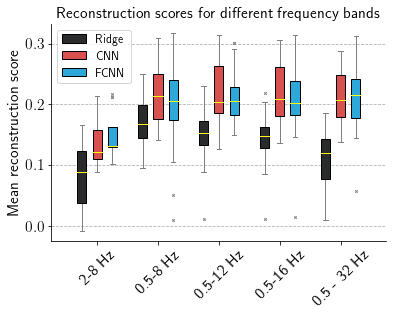

In [17]:
xticks = []
xticklabels = []
for i, key in enumerate(keys):
    for j, mdl in enumerate(aliases):
        plt.boxplot(freq_dfs[key][mdl]['means'], positions=[i+j/4], patch_artist=True,
                boxprops={'facecolor':colors[mdl], 'alpha':1, 'edgecolor':'black'},
                flierprops={'marker':'x', 'markersize':2.5, 'markeredgecolor':'grey'},
                whiskerprops={'color':'grey'},
                capprops={'color':'grey'},
                medianprops={'color':'yellow'})
    xticks.append(i+1/4)
    xticklabels.append(freqs[i])
        
plt.xticks(xticks, xticklabels, rotation=45)

labels = ["Ridge", "CNN", "FCNN"]
handles = [plt.Rectangle((0,0),1,1, facecolor=list(colors.values())[i], edgecolor='black') for i in range(3)]
plt.legend(handles, labels)
plt.ylabel("Mean reconstruction score")
plt.title("Reconstruction scores for different frequency bands")
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.grid(axis='y', linestyle='--', which='major')

plt.savefig("/home/mdt20/Documents/ESA_plots/freqs.eps")

# How do the pretrained models perform in different conditions, compared to the subject specific models?

In [179]:
conditions = ['clean', 'fW', 'fM', 'cleanDutch','lb','mb','hb', 'lbDutch', 'mbDutch', 'hbDutch']
window_results = {}
for window in [250, 625, 1250]:
    window_results[window] = {'means':None, 'stds':None, 'coeff_vars':None}
        
    means = {'ridge':{key:[] for key in conditions+['unatt']},
             'eegnet':{key:[] for key in conditions+['unatt']},
             'detaillez':{key:[] for key in conditions+['unatt']}}
    
    stds = {'ridge':{key:[] for key in conditions+['unatt']},
             'eegnet':{key:[] for key in conditions+['unatt']},
             'detaillez':{key:[] for key in conditions+['unatt']}}
    
    for cond in conditions:
        df, index0 = utils.get_results_octave(window, cond, os.path.join(results_path, 'generalisation'))
        for model in ['ridge', 'eegnet', 'detaillez']:
            means[model][cond] += [np.mean(df[f"{cond}_{model}_attended"].loc[i]) for i in df.index]
            stds[model][cond] += [np.std(df[f"{cond}_{model}_attended"].loc[i], ddof=1) for i in df.index]
            if cond == 'fW' or cond == 'fM':
                means[model]['unatt'] += [np.mean(df[f"{cond}_{model}_unattended"].loc[i]) for i in df.index]
                stds[model]['unatt'] += [np.std(df[f"{cond}_{model}_unattended"].loc[i], ddof=1) for i in df.index]

    for model in ['ridge', 'eegnet', 'detaillez']:
        means[model]['competing-speaker'] = means[model]['fW'] + means[model]['fM']
        means[model]['babble'] = means[model]['mb']
        stds[model]['competing-speaker'] = stds[model]['fW'] + stds[model]['fM']
        stds[model]['babble'] = stds[model]['mb']
        
    coeff_vars = {'ridge':{}, 'detaillez':{}, 'eegnet':{}}
        
    for model in ['ridge', 'eegnet', 'detaillez']:
        for cond in ['clean', 'cleanDutch', 'competing-speaker', 'babble', 'unatt']:
            means[model][cond] = np.array(means[model][cond])
            stds[model][cond] = np.array(stds[model][cond])
            coeff_vars[model][cond] = means[model][cond]/stds[model][cond]
            
    
    window_results[window]["means"] = means
    window_results[window]["stds"] = stds
    window_results[window]["coeff_vars"] = coeff_vars

In [180]:
colors = {"ridge":"#2A2B2DFF", "eegnet":"#D9514EFF", "detaillez":"#2DA8D8FF"}
prediction_windows = np.array(
    [3, 4, 5, 6, 7, 8, 9, 9, 11, 12, 13, 14, 15, 20, 30, 40, 50] + [125*i for i in range(1, 11)]
)

variances = {}
null_variances = {}
means = {}
null_means = {}
coeff_vars = {}

for window in prediction_windows:
    variances[window] = {}
    null_variances[window] = {}
    means[window] = {}
    null_means[window] = {}
    coeff_vars[window] = {}
    
    for model in ["ridge", "eegnet", "detaillez"]:
        r = json.load(open(os.path.join(results_path, model, study + "_results_{}".format(window) + ".json"), "r"))
        df = pd.DataFrame.from_dict(r).transpose()
        
        variances[window][model] = [np.asarray(df.loc[str(x)]["correlations"]) for x in range(13)]
        variances[window][model] = [x[~np.isnan(x)].std(ddof=1) for x in variances[window][model]]
        null_variances[window][model] = [np.asarray(df.loc[str(x)]["null_correlations"]) for x in range(13)]
        null_variances[window][model] = [x[~np.isnan(x)].std(ddof=1) for x in null_variances[window][model]]
        means[window][model] = [np.asarray(df.loc[str(x)]["correlations"]) for x in range(13)]
        means[window][model] = [x[~np.isnan(x)].mean() for x in means[window][model]]
        null_means[window][model] = [np.asarray(df.loc[str(x)]["null_correlations"]).mean() for x in range(13)]
        null_means[window][model] = [x[~np.isnan(x)].mean() for x in null_means[window][model]]
        coeff_vars[window][model] = np.array(means[window][model])/np.array(variances[window][model])
        
variances = pd.DataFrame.from_dict(variances).T
null_variances = pd.DataFrame.from_dict(null_variances).T
means = pd.DataFrame.from_dict(means).T
null_means = pd.DataFrame.from_dict(null_means).T
coeff_vars = pd.DataFrame.from_dict(coeff_vars).T

results_path = "/home/mdt20/Code/MLDecoders/results/141121/"
prediction_window = 250
study = "individuals"

dfs = utils.load_hugo_data(study, prediction_window, results_path)

/tmp/ipykernel_20744/174717743.py:30: RuntimeWarning: Mean of empty slice.
  null_means[window][model] = [x[~np.isnan(x)].mean() for x in null_means[window][model]]
/home/mdt20/miniconda3/envs/pytorch-hugo/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [181]:
markers = {'clean': {'marker': 'x', 'fillstyle':'none'},
           'cleanDutch': {'marker': 's', 'fillstyle':'none'},
           'competing-speaker': {'marker': 'o', 'fillstyle':'none'},
           'babble': {'marker': '^', 'fillstyle':'none'},
           'unatt': {'marker': 'o', 'fillstyle':'none'}}

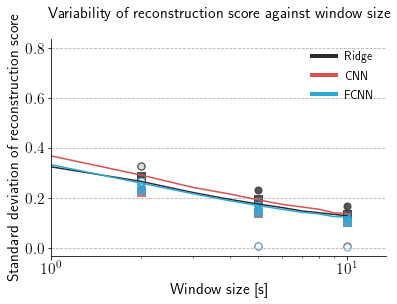

In [338]:
for model in aliases:
    
    mean_var = [np.mean(variances.loc[w][model]) for w in prediction_windows]
    plt.plot(prediction_windows*1/125,mean_var, color=colors[model], linestyle='-')

plt.xscale('log')

custom_lines = [Line2D([0], [0], color=colors['ridge'], lw=4),
                Line2D([0], [0], color=colors['eegnet'], lw=4),
                Line2D([0], [0], color=colors['detaillez'], lw=4)]

plt.legend(custom_lines, ['Ridge', 'CNN', 'FCNN'], loc='upper right', frameon=False)
plt.ylabel("Standard deviation of reconstruction score")
plt.xlabel("Window size [s]")
if title: plt.title("Variability of reconstruction score against window size \n")
plt.xlim(1, None)

ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

for window in [250,625,1250]:
    for model in aliases:
        for cond in ['clean', 'cleanDutch', 'competing-speaker', 'babble']:
            plt.scatter(window/125, np.mean(window_results[window]['stds'][model][cond]), s=50, c=colors[model], marker=MarkerStyle(**markers[cond]), alpha=0.8)
            
        plt.scatter(window/125, np.mean(window_results[window]['stds'][model]['unatt']), s=50, facecolor='w', edgecolor=colors[model], marker=MarkerStyle(**markers['unatt']), alpha=0.8)

plt.grid(axis='y', linestyle='--')
        

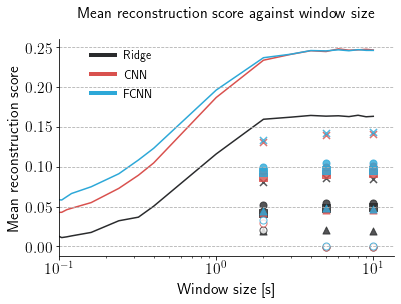

In [339]:
for model in aliases:
    
    mean = [np.mean(means.loc[w][model])*13/12 for w in prediction_windows]
    plt.plot(prediction_windows*1/125,mean, color=colors[model], zorder=1, linestyle='-')
        
plt.xscale("log")

custom_lines = [Line2D([0], [0], color=colors['ridge'], lw=4),
                Line2D([0], [0], color=colors['eegnet'], lw=4),
                Line2D([0], [0], color=colors['detaillez'], lw=4)]

plt.legend(custom_lines, ['Ridge', 'CNN', 'FCNN'], loc=(0.08,0.7), frameon=False)
plt.ylabel("Mean reconstruction score")
plt.xlabel("Window size [s]")
if title: plt.title("Mean reconstruction score against window size\n")
plt.xlim(0.1, None)

ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

for window in [250,625, 1250]:
    for model in aliases:
        for cond in ['clean', 'cleanDutch', 'competing-speaker', 'babble']:
            plt.scatter(window/125, np.mean(window_results[window]['means'][model][cond]), s=50, c=colors[model], marker=MarkerStyle(**markers[cond]), alpha=0.8)
            
        plt.scatter(window/125, np.mean(window_results[window]['means'][model]['unatt']), s=50, facecolor='w', edgecolor=colors[model], marker=MarkerStyle(**markers['unatt']), alpha=0.8)

plt.grid(axis='y', linestyle='--')

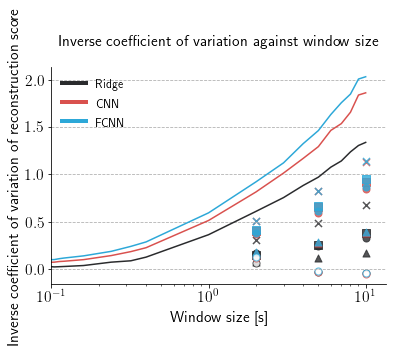

In [340]:
for model in aliases:
    
    mean_var = np.array([np.power(np.prod(variances.loc[w][model]), 1/13) for w in prediction_windows])
    mean = np.array([np.mean(means.loc[w][model])*13/12 for w in prediction_windows])
    coeff_var = np.array([np.mean(coeff_vars.loc[w][model])*13/12 for w in prediction_windows])
    #coeff_var = mean/np.sqrt(mean_var)
    plt.plot(prediction_windows*1/125,coeff_var, color=colors[model], linestyle='-')
        
plt.xscale('log')

custom_lines = [Line2D([0], [0], color=colors['ridge'], lw=4),
                Line2D([0], [0], color=colors['eegnet'], lw=4),
                Line2D([0], [0], color=colors['detaillez'], lw=4)]

plt.legend(custom_lines, ['Ridge', 'CNN', 'FCNN'], frameon=False)
plt.ylabel("Inverse coefficient of variation of reconstruction score")
plt.xlabel("Window size [s]")
if title: plt.title("Inverse coefficient of variation against window size \n")
plt.xlim(0.1, None)

ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

for window in [250, 625, 1250]:
    for model in aliases:
        for cond in ['clean', 'cleanDutch', 'competing-speaker', 'babble']:
            plt.scatter(window/125, np.mean(window_results[window]['coeff_vars'][model][cond]), s=50, c=colors[model], marker=MarkerStyle(**markers[cond]), alpha=0.8)
            
        plt.scatter(window/125, np.mean(window_results[window]['coeff_vars'][model]['unatt']), s=50, facecolor='w', edgecolor=colors[model], marker=MarkerStyle(**markers['unatt']), alpha=0.8)

plt.grid(axis='y', linestyle='--') 

# Plot means for entire test data

In [136]:
def get_stars(p):

    if p <= 0.00001:
        return "*****"
    elif p <= 0.0001:
        return "****"
    elif p <= 0.001:
        return "***"
    elif p <= 0.01:
        return "**"
    elif p <= 0.05:
        return "*"
    elif p > 0.05:
        return ""

def add_sig(ax, x1, x2, y, headwidth=0.01, headpos='top', width=1):
    ax.plot([x1,x2], [y,y], color='black', lw=width)
    if headpos=='top':
        ax.plot([x1,x1], [y,y+headwidth],    color='black', lw=width)
        ax.plot([x2,x2], [y,y+headwidth],    color='black', lw=width)
    if headpos=='bottom':
        ax.plot([x1,x1], [y,y-headwidth],    color='black', lw=width)
        ax.plot([x2,x2], [y,y-headwidth], color='black', lw=width)
        
    return ax

In [350]:
results = json.load(open(os.path.join(results_path, 'generalisation', 'predictions.json'), 'r'))

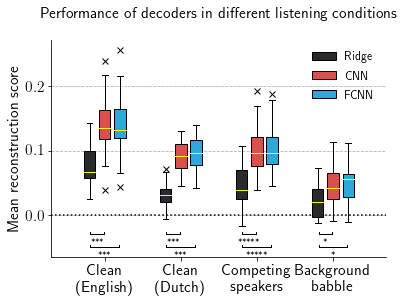

In [351]:
conditions = ['clean', 'fW', 'fM', 'cleanDutch','mb']
data = {'ridge':{key:[] for key in conditions},
        'eegnet':{key:[] for key in conditions},
        'detaillez':{key:[] for key in conditions}}

for cond in conditions:
    for j, model in enumerate(['ridge', 'eegnet', 'detaillez']):
        for p in results[cond].keys():
            if p =='truth':continue
            length = min(len(results[cond][p][j]), len(results[cond]['truth'][1][:length]))
            data[model][cond].append(pearsonr(results[cond][p][j][:length], results[cond]['truth'][1][:length])[0])
    
for model in ['ridge', 'eegnet', 'detaillez']:
    data[model]['competing-speaker'] = data[model]['fW'] + data[model]['fM']
    data[model]['babble'] = data[model]['mb']

p_vals = np.zeros((4,3,3))
    
for i, cond in enumerate(['clean', 'cleanDutch', 'competing-speaker', 'babble']):
    for j, model in enumerate(['ridge', 'eegnet', 'detaillez']):
        bp = plt.boxplot(data[model][cond],
                    positions = [i + (j-1)*1/5],
                    patch_artist=True,
                    boxprops = {'facecolor':colors[model], 'edgecolor':'black'},
                    medianprops={'color':'yellow'},
                    flierprops={'marker':'x'})
        for k, m in enumerate(['ridge', 'eegnet', 'detaillez']):
            if k <= j:
                continue
            p_vals[i,j, k] = ranksums(data[model][cond], data[m][cond])[1]
            
p_vals_corrected = multitest.fdrcorrection(p_vals[p_vals!=0])[1]
p_vals[p_vals!=0] = p_vals_corrected

for i, cond in enumerate(['clean', 'cleanDutch', 'competing-speaker', 'babble']):
    for j, model in enumerate(['ridge', 'eegnet', 'detaillez']):
        for k, m in enumerate(['ridge', 'eegnet', 'detaillez']):
            if k <= j:
                continue
            p = p_vals[i,j,k]
            stars = get_stars(p)
            if p < 0.05:
                if j==0 and k==2:
                    y =  - 0.05

                else:
                    y = - 0.03

                add_sig(plt.gca(), i + (j-1)*1/5 +0.01, i + (k-1)*1/5 - 0.01, y, headwidth=0.004, headpos='top')
                plt.text(i + ((j+k)/2-1)*1/5, y-0.012, stars, ha='center', size='small')


custom_lines = [plt.Rectangle((0,0),1,1, facecolor=colors['ridge'], edgecolor='black'),
            plt.Rectangle((0,0),1,1, facecolor=colors['eegnet'], edgecolor='black'),
            plt.Rectangle((0,0),1,1, facecolor=colors['detaillez'], edgecolor='black')]

plt.legend(custom_lines, ['Ridge', 'CNN', 'FCNN'], loc='upper right', frameon=False)

ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.axhline(0, color='black', linestyle='dotted')
plt.xticks(np.array([0,1,2,3]), ['Clean\n(English)', 'Clean\n(Dutch)', 'Competing\nspeakers', 'Background\nbabble'])

plt.ylabel("Mean reconstruction score")
if title: plt.title("Performance of decoders in different listening conditions\n")
plt.grid(axis='y', linestyle='--')

# How well is the unattended talker tracked (different window sizes)

In [352]:
absolute_tracking = {'ridge':[],
                     'eegnet':[],
                     'detaillez':[]}

for cond in ['fW', 'fM']:
    df, index0 = utils.get_results_octave(prediction_window, cond, os.path.join(results_path, 'generalisation'))
    for j, model in enumerate(['ridge', 'eegnet', 'detaillez']):
        for p in results[cond].keys():
            if p =='truth':continue
            length = min(len(results[cond][p][j]), len(results[cond]['truth'][0][:length]))
            absolute_tracking[model].append(pearsonr(results[cond][p][j][:length], results[cond]['truth'][0][:length])[0])

In [424]:
def get_scores(y, y_hat, batch_size=1250, metric=pear):
    batches = y.size//batch_size - 1
    scores = []
    for i in range(batches):
        scores.append(metric(y[i*batch_size:(i+1)*batch_size], y_hat[i*batch_size:(i+1)*batch_size]))
    return np.array(scores)

In [342]:
windowed_tracking = {}
windows = [125, 250, 500, 1250]
for window in windows:
    windowed_tracking[window] = {'ridge':[],
                     'eegnet':[],
                     'detaillez':[]}
    
    for cond in ['fW', 'fM']:
        df, index0 = utils.get_results_octave(prediction_window, cond, os.path.join(results_path, 'generalisation'))
        for j, model in enumerate(['ridge', 'eegnet', 'detaillez']):
            for p in results[cond].keys():
                if p =='truth':continue
                length = min(len(results[cond][p][j]), len(results[cond]['truth'][0][:length]))
                tmp = list(get_scores(np.array(results[cond][p][j][:length]),
                                      np.array(results[cond]['truth'][0][:length]),window))
                windowed_tracking[window][model].append(np.mean(tmp))

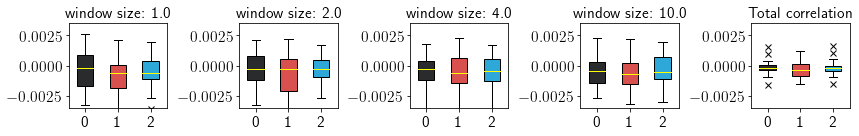

In [343]:
fig, axs = plt.subplots(1,len(windows)+1, tight_layout=True, figsize=(12,2))

for i, model in enumerate(aliases):
    for j, window in enumerate(windows):
        axs[j].boxplot(windowed_tracking[window][model], positions=[i], patch_artist=True,
                    boxprops = {'facecolor':colors[model], 'edgecolor':'black'},
                    medianprops={'color':'yellow'},
                    flierprops={'marker':'x'},
                    widths=0.5)
        axs[j].set_ylim(-0.0035, 0.0035)
        axs[j].set_title(f"window size: {window/125}")

    axs[-1].boxplot(absolute_tracking[model], positions=[i], patch_artist=True,
                    boxprops = {'facecolor':colors[model], 'edgecolor':'black'},
                    medianprops={'color':'yellow'},
                    flierprops={'marker':'x'},
                    widths=0.5);
    axs[-1].set_ylim(-0.0035, 0.0035)
    axs[-1].set_title("Total correlation")

# Compare the scores achieved by each model

In [372]:
df, index0 = utils.get_results_octave(250, 'clean', os.path.join(results_path, 'generalisation'))

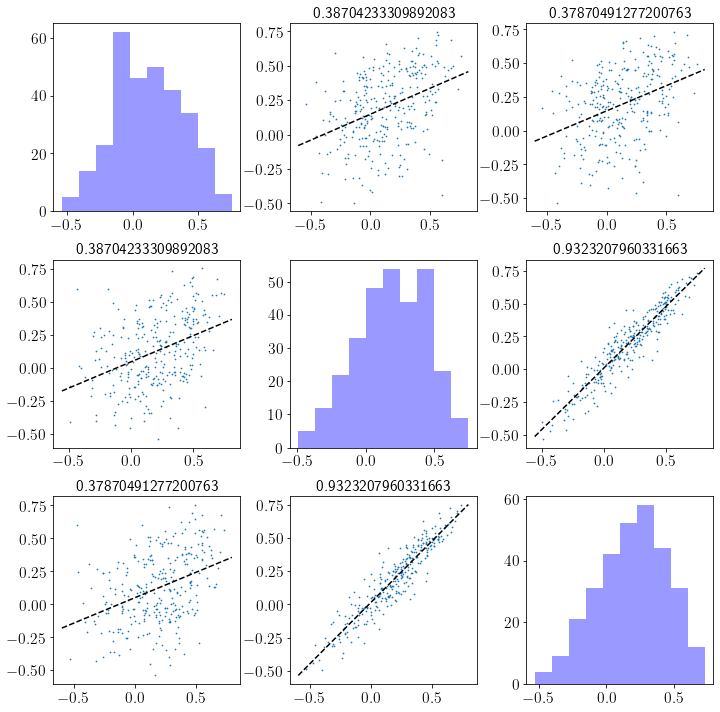

In [392]:
test_participant = 'YH20'

fig, axs = plt.subplots(3,3,tight_layout=True, figsize=(10,10))

for i, mdl_i in enumerate(aliases):
    for j, mdl_j in enumerate(aliases):
        if i == j:
            axs[i,j].hist(df[f'clean_{mdl_i}_attended'].loc[test_participant], color='blue', alpha=0.4, bins=10)
        else:
            scoresi = np.array(df[f'clean_{mdl_i}_attended'].loc[test_participant])
            scoresj = np.array(df[f'clean_{mdl_j}_attended'].loc[test_participant])
            idx_i = ~np.isnan(scoresi)
            idx_j = ~np.isnan(scoresj)
            idx = np.array([p for p in idx_i if p in idx_j])
            axs[i,j].scatter(scoresi[idx], scoresj[idx], s=0.5)
            axs[i, j].set_title(pearsonr(scoresi[idx], scoresj[idx])[0])
            
            p = np.polyfit(scoresi[idx], scoresj[idx], 1)
            xmin, xmax = axs[i, j].get_xlim()
            x = np.linspace(xmin, xmax, 100)
            axs[i, j].plot(x, p[0]*x + p[1], color='black', linestyle='--')

In [377]:
def sigmoid(k,x,x0,x1,x2):
    return (x1 / (1 + np.exp(-k*(x-x0))) + x2)

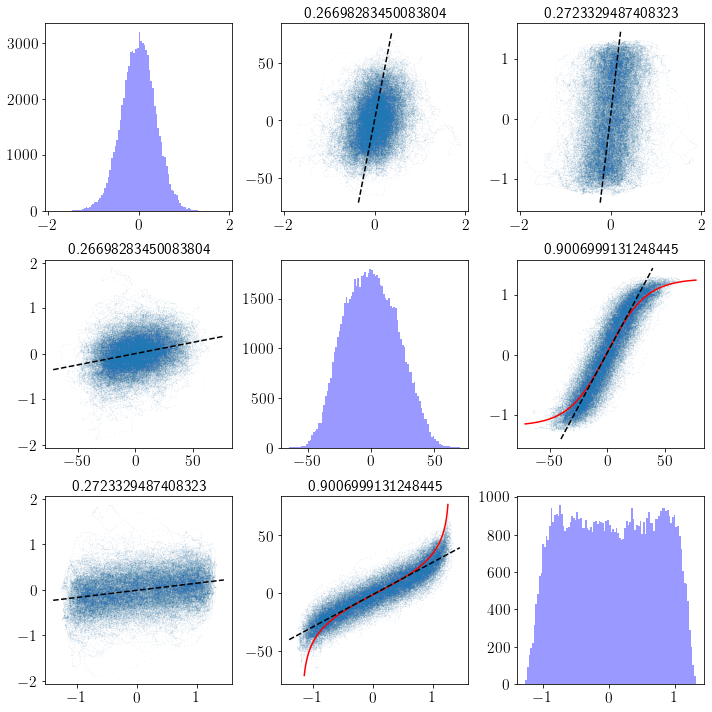

In [394]:
test_participant = 'YH20'

fig, axs = plt.subplots(3,3,tight_layout=True, figsize=(10,10))

for i, mdl_i in enumerate(aliases):
    for j, mdl_j in enumerate(aliases):
        if i == j:
            axs[i,j].hist(np.array(results['clean'][test_participant][i]), color='blue', alpha=0.4, bins=100)
        else:
            scoresi = np.array(results['clean'][test_participant][i])
            scoresj = np.array(results['clean'][test_participant][j])
            axs[i,j].scatter(scoresi, scoresj, s=0.0005)
            axs[i, j].set_title(pearsonr(scoresi, scoresj)[0])
            
            if i > j:
            
                p = np.polyfit(scoresi, scoresj, 1)
                xmin, xmax = axs[i, j].get_xlim()
                x = np.linspace(xmin, xmax, 100)
                axs[i, j].plot(x, p[0]*x + p[1], color='black', linestyle='--')
                axs[j, i].plot(p[0]*x + p[1], x, color='black', linestyle='--')
            
            if i == 1 and j == 2:
                popt, pcov = curve_fit(sigmoid, scoresi, scoresj)
                y = sigmoid(x, *popt)
                axs[i, j].plot(x, y, color='red')
                axs[j, i].plot(y, x, color='red')

# AAD

In [430]:
# combine fM, fW

competing_speakers_results = {}
for participant in english_participants:
    competing_speakers_results[participant] = {}
    
    ridge_W = results['fW'][participant][0]
    att = results['fW']['truth'][1]
    unatt = results['fW']['truth'][0]
    length = min(len(ridge_W), len(att))
    
    competing_speakers_results[participant]['predictions'] = ridge_W[:length]
    competing_speakers_results[participant]['att'] = att[:length]
    competing_speakers_results[participant]['unatt'] = unatt[:length]
    
    ridge_M = results['fM'][participant][0]
    att = results['fM']['truth'][1]
    unatt = results['fM']['truth'][0]
    length = min(len(ridge_M), len(att))
    
    competing_speakers_results[participant]['predictions'] += ridge_M[:length]
    competing_speakers_results[participant]['att'] += att[:length]
    competing_speakers_results[participant]['unatt'] += unatt[:length]
    
    for key in competing_speakers_results[participant].keys():
        competing_speakers_results[participant][key] = np.array(competing_speakers_results[participant][key])

/home/mdt20/miniconda3/envs/pytorch-hugo/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/mdt20/miniconda3/envs/pytorch-hugo/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/mdt20/miniconda3/envs/pytorch-hugo/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/mdt20/miniconda3/envs/pytorch-hugo/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/mdt20/mini

/home/mdt20/miniconda3/envs/pytorch-hugo/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/mdt20/miniconda3/envs/pytorch-hugo/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/mdt20/miniconda3/envs/pytorch-hugo/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/mdt20/miniconda3/envs/pytorch-hugo/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/mdt20/mini

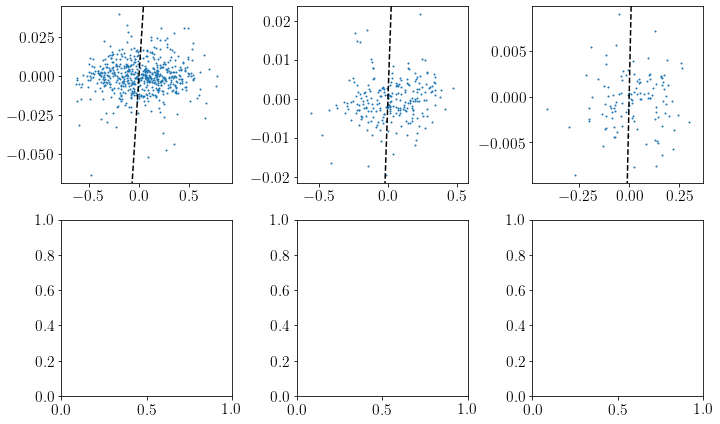

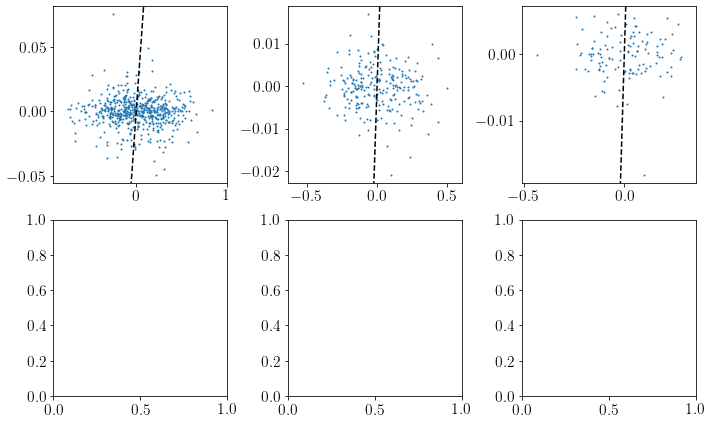

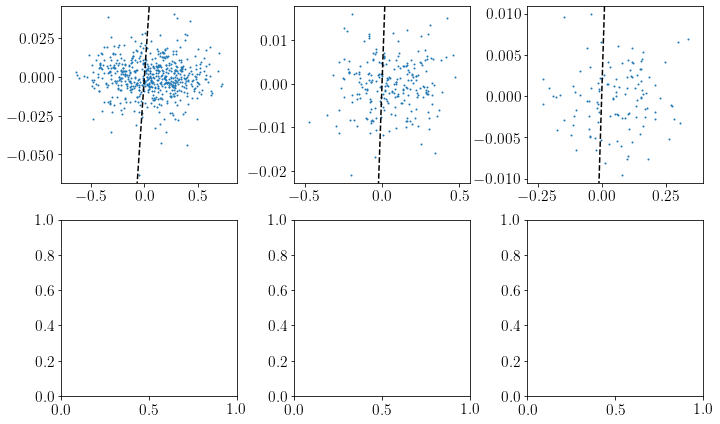

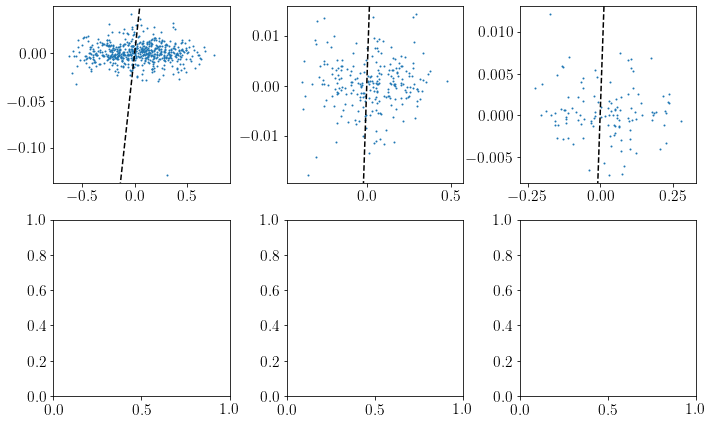

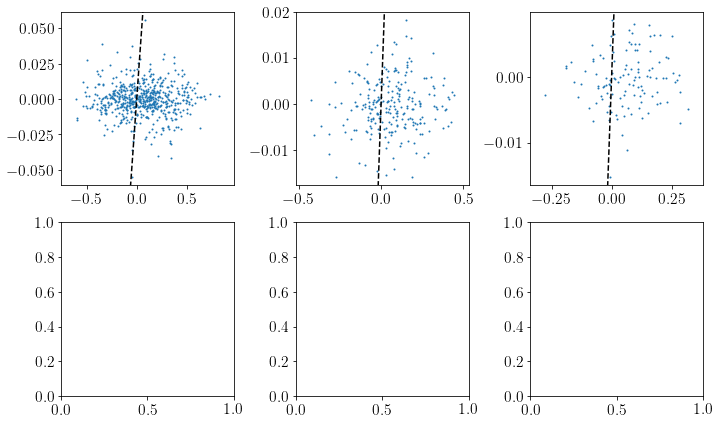

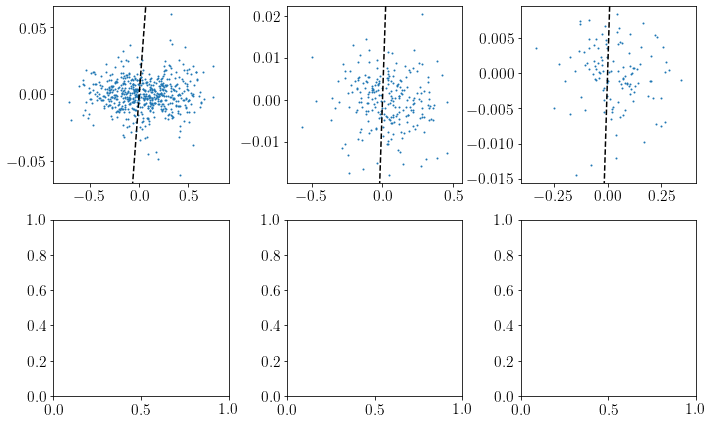

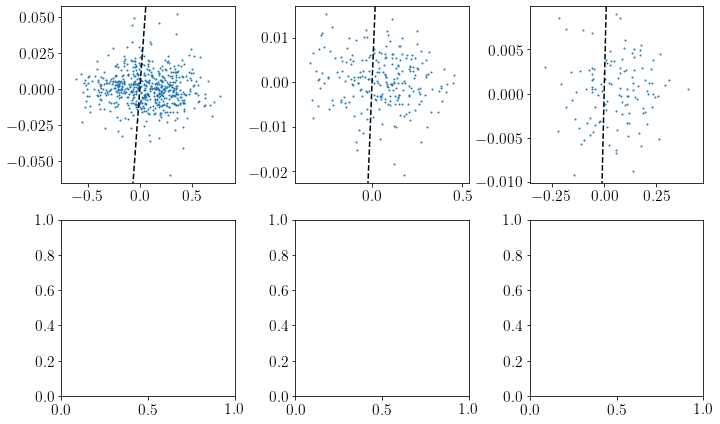

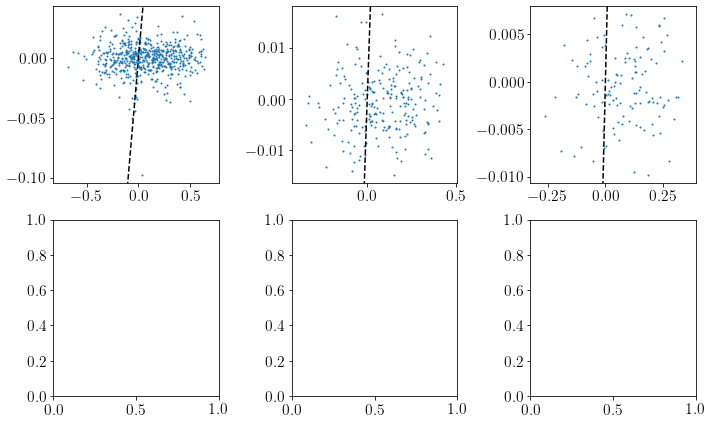

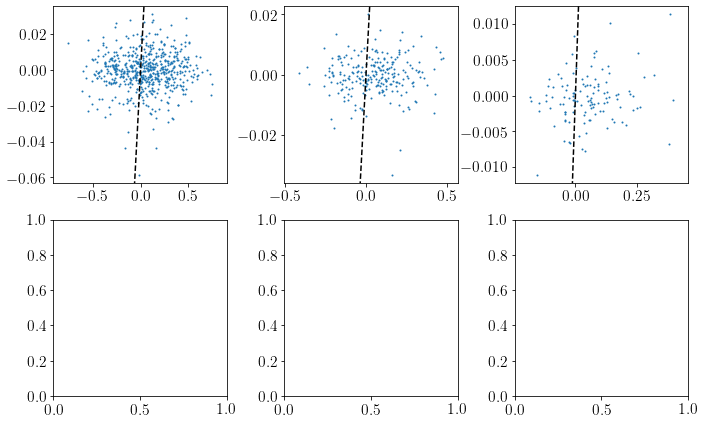

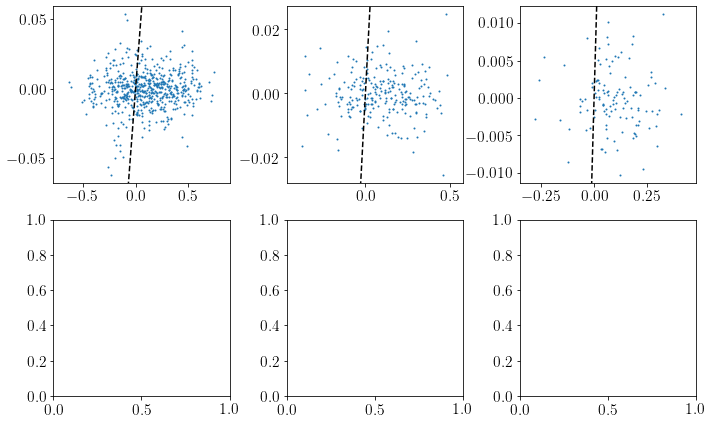

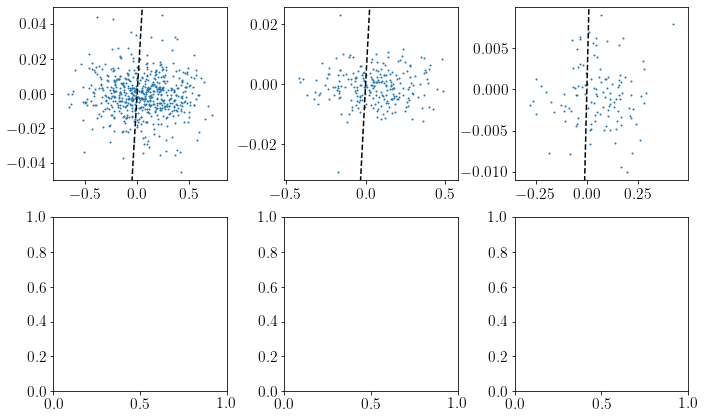

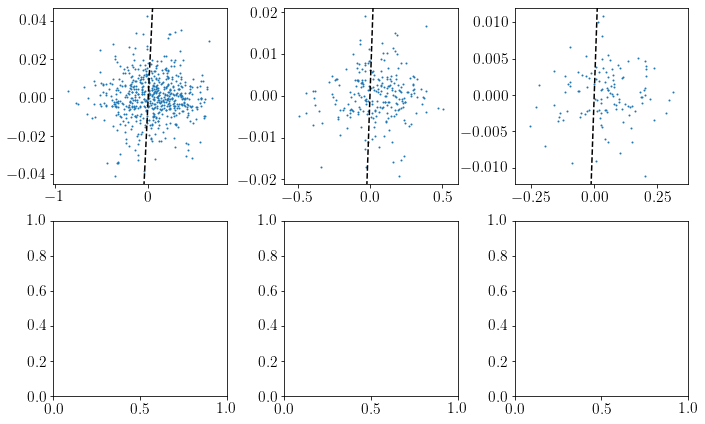

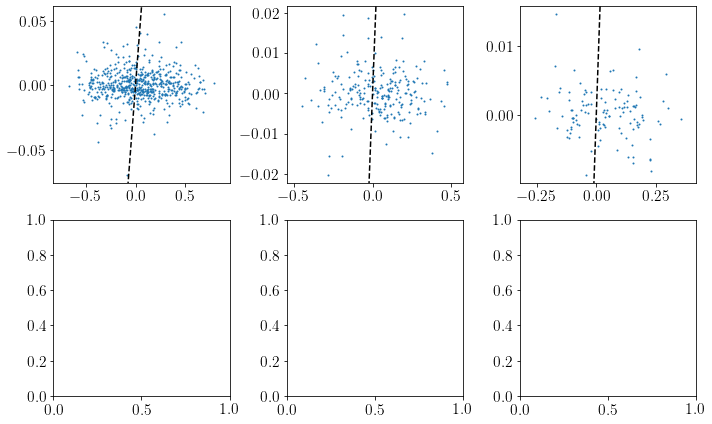

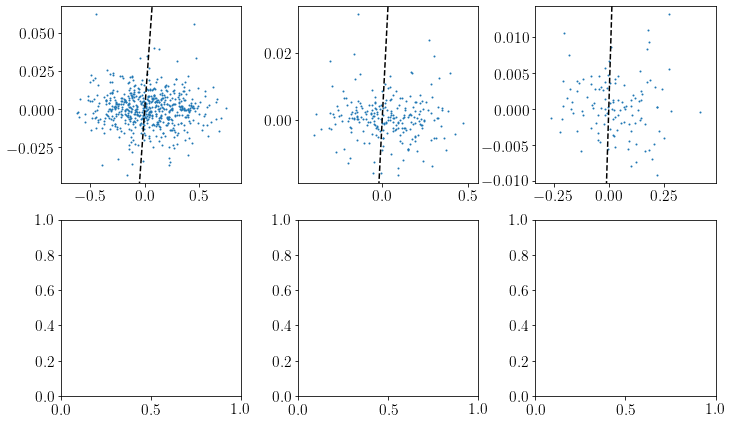

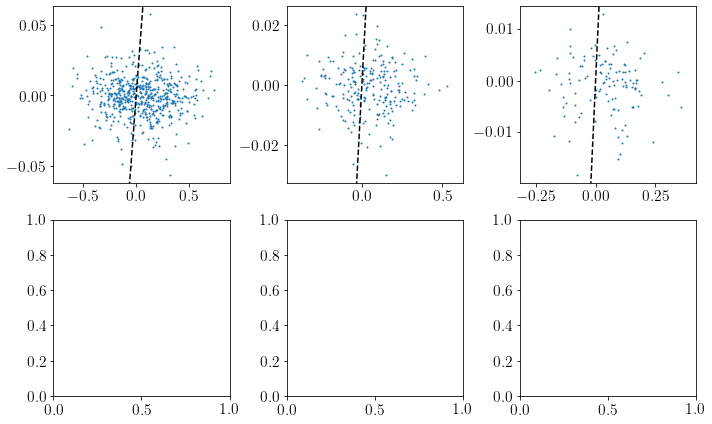

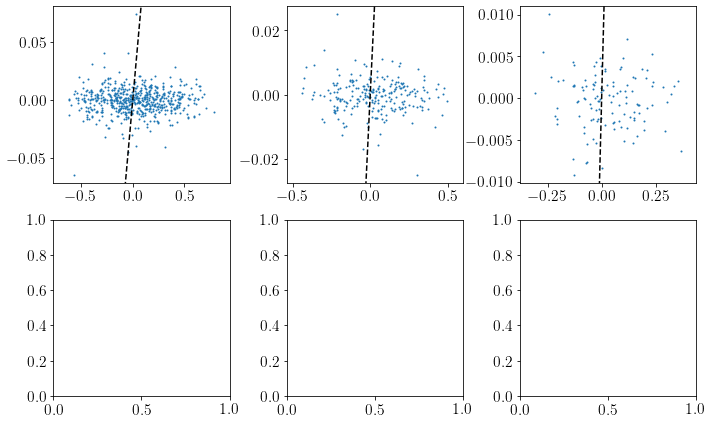

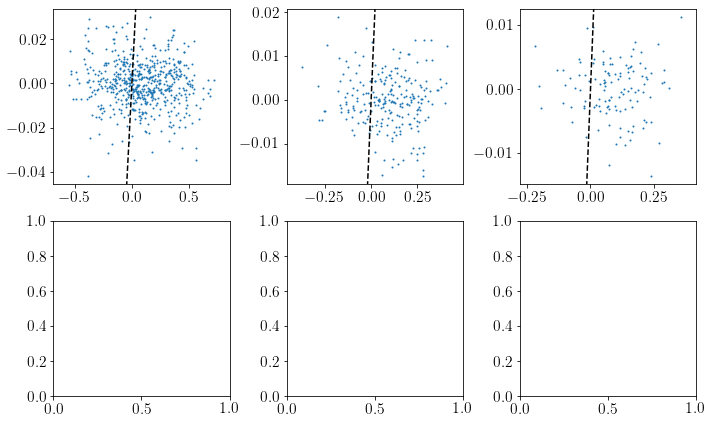

In [441]:
metric = pear
for participant in english_participants:
    fig, axs = plt.subplots(2, 3, tight_layout=True, figsize=(10,6))
    for i, window in enumerate([250, 625, 1250]):
        a = get_scores(competing_speakers_results[participant]['predictions'],
                       competing_speakers_results[participant]['att'],
                       batch_size=window,
                       metric=pear)
        u = get_scores(competing_speakers_results[participant]['predictions'],
                       competing_speakers_results[participant]['unatt'],
                       batch_size=window,
                       metric=pear)
        axs[0, i].scatter(a,u, s=1)
        xmin, xmax = axs[0,i].get_xlim()
        ylim = axs[0,i].get_ylim()
        x = np.linspace(xmin, xmax, 20)
        axs[0, i].plot(x,x,linestyle='--', color='black')
        axs[0, i].set_ylim(*ylim)

In [400]:
# similarity metrics

def med_ae(x,y):
    return np.median(np.abs(x-y))

def med_se(x,y):
    return np.median(np.square(x-y))

def mean_se(x,y):
    return np.mean(np.square(x-y))

def trim_mean_se(x,y,trim=0.1):
    return trim_mean(np.square(x-y), trim).mean()
    
def trim_med_ae(x,y,trim=0.1):
    return np.median(trim_mean(np.abs(x-y), trim))

def spear(x,y):
    return spearmanr(x, y)[0]

def pear(x,y):
    return pearsonr(x, y)[0]

def var_se(x,y):
    w,v = np.linalg.eigh(np.cov(x, y))
    return np.cov(x, y)[1,0]

def std_ae(x,y):
    return np.std(np.abs(x-y))

[0.018022380748930873,
 0.013986526379559874,
 0.019064235738152503,
 0.03071455967133006,
 0.052151530584655124,
 0.07499187348822961,
 0.09863902379530526,
 0.1143430507205817,
 0.12042797706913803,
 0.11387583410667403,
 0.09817781886410948,
 0.07411191111370471,
 0.05029638406690398,
 0.030122735056234043,
 0.020318066602885,
 0.018152900972349353,
 0.02535123291862061,
 0.03725991651572752,
 0.05483440319016872,
 0.07595124823956313,
 0.10153377270150003,
 0.1267421179546827,
 0.1561671771222366,
 0.18570033531619412,
 0.21404898362449346,
 0.23913829720450108,
 0.26001725548752214,
 0.2737549159554623,
 0.27886741849776314,
 0.2759507736666196,
 0.2715766511827081,
 0.26557536710939045,
 0.2626776567048046,
 0.2638313877083088,
 0.27027785337455806,
 0.27731823169665226,
 0.2807788559639623,
 0.2757607157631469,
 0.26207807093038005,
 0.2423004536086953,
 0.2213459812748919,
 0.20235739301469452,
 0.1915529314475577,
 0.1940239623353191,
 0.21210650293216882,
 0.2401450203742947,